## Notebook to understand working with wavefront objects in and out of SRW

In [1]:
#Import necessary libraries
from __future__ import print_function #Python 2.7 compatibility

%load_ext autoreload
%autoreload 2

from copy import deepcopy
import math
import numpy as np
import os 
import scipy.constants as const
import sys
import time

import rslaser.utils.constants as rsc
import rslaser.rsoptics.wavefront as rswf
import srwlib
from srwlib import srwl

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}

In [2]:
#Create Gaussian wavefront
##Create Gaussian wavefront
#sigr: requested RMS beam size [m]
#propLen: propagation length required by SRW to create numerical Gaussian [m]
#pulseE: energy per pulse [J]
#poltype: polarization type (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
#phE: photon energy [eV]
#sampFact: sampling factor to increase mesh density

sigrW = 1e-3
propLen = 15  ##20
pulseE = .001
poltype = 1
phE = 0.124 #Energy in eV corresponding to 10 micron wavelength
sampFact = 5 ##25, 44, 60
constConvRad = 1.23984186e-06/(4*3.1415926536)  ##conversion from energy to 1/wavelength
rmsAngDiv = constConvRad/(phE*sigrW)
print("RMS beam divergence at waist: %s radians" %(rmsAngDiv))
mx = 2
my = 2

# create a Gaussian wavefront in SRW
wfr0 = rswf.createGsnSrcSRW(sigrW,propLen,pulseE,poltype,phE,sampFact,mx,my)
print("Initial wavefront calculated on a grid of %d x %d points" %(wfr0.mesh.nx,wfr0.mesh.ny))

RMS beam divergence at waist: 0.0007956732285105183 radians
Initial wavefront calculated on a grid of 500 x 500 points


In [3]:
##Convert energy to wavelength
phLambda = const.h * const.c / phE
print("Wavelength corresponding to %s keV: %.4s microns" %(phE*1e-3,phLambda*1e6))

Wavelength corresponding to 0.000124 keV: 1.60 microns


Size of initial wavefront data array (coordinate): (500, 500)


Text(0.5, 1.0, 'Intensity at Waist')

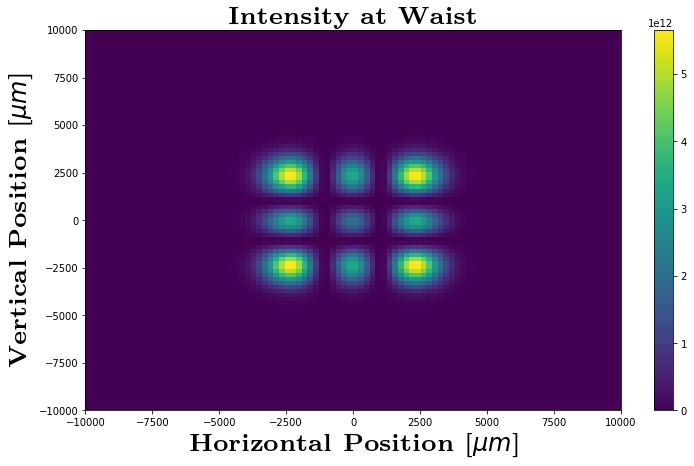

In [6]:
#Plot initial wavefront
##Initial wfr calculation
arIinit = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity
##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-1e4,1e4)
ax.set_xlim(-1e4,1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity at Waist',**hfontLarge)

In [7]:
#Export initial wavefront to file
fname="InitialWavefrontArray.txt"
np.shape(arIinit2D)
np.savetxt(fname, arIinit2D, fmt='%.18e')

In [9]:
##Construct 1:1 beamline in SRW and propagate Gaussian through it
##Parameters for 1 to 1 focusing beamline creation, createBL1to1(L,dfof)
#L: total path length
#dfof: focal length variation factor (=0 for no variation; can be positive or negative)
L=15.  ##Drift length before and after lens

wfr1 = deepcopy(wfr0)
#srwl.ResizeElecField(wfr1, 'c', [1, 5, 15, 5, 15])

wfrsizef=(wfr1.mesh.nx*wfr1.mesh.ny)

optBL1to1 = rswf.createBL1to1(L,dfof=0)
start_time = time.time()
srwl.PropagElecField(wfr1, optBL1to1)
print("Propagation time: %s seconds" %(round((time.time() - start_time),5)))

Propagation time: 6.44756 seconds


In [ ]:
#Extract final array and export to numpy array
arIf = srwlib.array('f', [0]*wfr1.mesh.nx*wfr1.mesh.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIf, wfr1, 6, 0, 3, wfr1.mesh.eStart, 0, 0) #extracts intensity
##Reshaping electric field data from flat to 2D array
arIf2D = np.array(arIf).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')

xvalsf02=np.linspace(wfr1.mesh.xStart,wfr1.mesh.xFin,wfr1.mesh.nx)
yvalsf02=np.linspace(wfr1.mesh.yStart,wfr1.mesh.yFin,wfr1.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIf2D, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-1e4,1e4)
ax.set_xlim(-1e4,1e4)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity after propagation',**hfontLarge)

Text(0.5, 1.0, 'Intensity after propagation')